In [204]:
import ast
import itertools
import pickle

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# always import sklearnex before sklearn
from sklearnex import patch_sklearn
patch_sklearn()



Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [212]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                            ConfusionMatrixDisplay, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [24]:
pd.options.mode.copy_on_write = True

## Загрузка данных

In [25]:
data_path = Path("../data/HDFS_v1/preprocessed/")
hdfs1_csv = {
    'traces': 'Event_traces.csv',
    'templates': 'HDFS.log_templates.csv'
    }


### Шаблоны событий

In [26]:
templates = pd.read_csv(
        data_path / hdfs1_csv['templates'],
        dtype={
            'EventId': pd.StringDtype(),
            'EventTemplate': pd.StringDtype()}
    )

In [27]:
templates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   EventId        29 non-null     string
 1   EventTemplate  29 non-null     string
dtypes: string(2)
memory usage: 596.0 bytes


### Последовательности событий

In [28]:
traces = pd.read_csv(data_path / hdfs1_csv['traces'],
    dtype={
        'BlockId': pd.StringDtype(),
        'Label': pd.CategoricalDtype(),
        'Type': pd.CategoricalDtype(),
        # 'Type': pd.StringDtype(),
        'Features': pd.StringDtype(),
        'TimeInterval': pd.StringDtype(),
        'Latency': pd.Int32Dtype()
        }
    )


In [29]:
traces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   BlockId       575061 non-null  string  
 1   Label         575061 non-null  category
 2   Type          16838 non-null   category
 3   Features      575061 non-null  string  
 4   TimeInterval  575061 non-null  string  
 5   Latency       575061 non-null  Int32   
dtypes: Int32(1), category(2), string(3)
memory usage: 17.0 MB


In [30]:
def parse_time_interval(v: str):
    return np.array(ast.literal_eval(v), np.int32)

In [31]:
traces['TimeInterval_Array'] = traces['TimeInterval'].apply(parse_time_interval)

In [32]:
traces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   BlockId             575061 non-null  string  
 1   Label               575061 non-null  category
 2   Type                16838 non-null   category
 3   Features            575061 non-null  string  
 4   TimeInterval        575061 non-null  string  
 5   Latency             575061 non-null  Int32   
 6   TimeInterval_Array  575061 non-null  object  
dtypes: Int32(1), category(2), object(1), string(3)
memory usage: 21.4+ MB


In [33]:
traces.TimeInterval.memory_usage(deep=True), traces.TimeInterval_Array.memory_usage(deep=True)

(86590855, 111409724)

#### Соотношение классов

In [35]:
traces['Label'].value_counts(normalize=True)

Label
Success    0.97072
Fail       0.02928
Name: proportion, dtype: float64

#### Параметры модели

In [45]:
features = traces.copy()

In [69]:
features['EventsList'] = features['Features'].str.strip('[]').str.split(',')

#### Свойства последовательности событий

##### Длина последовательности

In [73]:
features['SequenceLength'] = features['EventsList'].apply(len)

In [74]:
features.SequenceLength.head(3)

0    269
1     22
2    223
Name: SequenceLength, dtype: int64

##### Колличество уникальных событий

In [75]:
features['UniqueEvents']= features['EventsList'].apply(set)

In [81]:
features['UniqueEventsCount'] = features['UniqueEvents'].apply(len).astype(pd.Int32Dtype())

In [82]:
features.UniqueEventsCount.value_counts()

UniqueEventsCount
7     300439
5      96317
9      77147
10     54698
8      29935
6       5801
3       3231
2       2950
11      2224
12       820
13       745
14       703
15        15
16        14
17        11
18         6
19         4
20         1
Name: count, dtype: Int64

In [83]:
features['EventDensity'] = features['UniqueEventsCount'] / features['SequenceLength']

In [84]:
features.EventDensity.head(3)

0     0.04461
1    0.409091
2    0.040359
Name: EventDensity, dtype: Float64

In [63]:
stats = {   'TI_mean': np.mean,
            'TI_max': np.max,
            'TI_min': np.min,
            'TI_std': np.std}

In [64]:
for name, func in stats.items():
    features[name] = features.TimeInterval_Array.apply(func)

In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   BlockId             575061 non-null  string  
 1   Label               575061 non-null  category
 2   Type                16838 non-null   category
 3   Features            575061 non-null  string  
 4   TimeInterval        575061 non-null  string  
 5   Latency             575061 non-null  Int32   
 6   TimeInterval_Array  575061 non-null  object  
 7   SequenceLength      575061 non-null  int64   
 8   UniqueEvents        575061 non-null  object  
 9   EventDensity        575061 non-null  Float64 
 10  TI_mean             575061 non-null  float64 
 11  TI_max              575061 non-null  int32   
 12  TI_min              575061 non-null  int32   
 13  TI_std              575061 non-null  float64 
 14  IsLongOperation     575061 non-null  Int8    
 15  EventsPerMS      

In [66]:
latency_95th = features.Latency.quantile(0.95)

In [67]:
features['IsLongOperation'] = (features['Latency'] > latency_95th).astype(pd.Int8Dtype())

In [68]:
features['EventsPerMS'] = features.SequenceLength / features.Latency

In [94]:
def consequtive_events(evens):
    """Число одинаковых последовательных событий"""
    return sum([len(list(v)) for k, v in itertools.groupby(evens)])

In [95]:
features['EventsConsequtiveCount'] = features['EventsList'].apply(consequtive_events)

In [96]:
def events_unique_transitions_count(evens):
    """Число уникальных переходов между событиями"""
    return len(set(itertools.pairwise(evens)))

In [97]:
features['EventsUniqueTransitionsCount'] = features['EventsList'].apply(events_unique_transitions_count)

In [98]:
features.EventsUniqueTransitionsCount.head(3)

0    38
1    15
2    16
Name: EventsUniqueTransitionsCount, dtype: int64

In [99]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   BlockId                       575061 non-null  string  
 1   Label                         575061 non-null  category
 2   Type                          16838 non-null   category
 3   Features                      575061 non-null  string  
 4   TimeInterval                  575061 non-null  string  
 5   Latency                       575061 non-null  Int32   
 6   TimeInterval_Array            575061 non-null  object  
 7   SequenceLength                575061 non-null  int64   
 8   UniqueEvents                  575061 non-null  object  
 9   EventDensity                  575061 non-null  Float64 
 10  TI_mean                       575061 non-null  float64 
 11  TI_max                        575061 non-null  int32   
 12  TI_min                        

### Матрица параметров модели

In [100]:
features.columns

Index(['BlockId', 'Label', 'Type', 'Features', 'TimeInterval', 'Latency',
       'TimeInterval_Array', 'SequenceLength', 'UniqueEvents', 'EventDensity',
       'TI_mean', 'TI_max', 'TI_min', 'TI_std', 'IsLongOperation',
       'EventsPerMS', 'EventsList', 'UniqueEventsCount',
       'EventsConsequtiveCount', 'EventsUniqueTransitionsCount'],
      dtype='object')

In [141]:
features_columns = [
    'Latency',
    'SequenceLength',
    'EventDensity',
    'TI_mean',
    'TI_max',
    'TI_min',
    'TI_std',
    'IsLongOperation',
    # 'EventsPerMS',
    'UniqueEventsCount',
    'EventsConsequtiveCount',
    'EventsUniqueTransitionsCount'
    ]

In [142]:
X = features[features_columns].copy()

In [143]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Latency                       575061 non-null  Int32  
 1   SequenceLength                575061 non-null  int64  
 2   EventDensity                  575061 non-null  Float64
 3   TI_mean                       575061 non-null  float64
 4   TI_max                        575061 non-null  int32  
 5   TI_min                        575061 non-null  int32  
 6   TI_std                        575061 non-null  float64
 7   IsLongOperation               575061 non-null  Int8   
 8   UniqueEventsCount             575061 non-null  Int32  
 9   EventsConsequtiveCount        575061 non-null  int64  
 10  EventsUniqueTransitionsCount  575061 non-null  int64  
dtypes: Float64(1), Int32(2), Int8(1), float64(2), int32(2), int64(3)
memory usage: 37.8 MB


In [144]:
X.describe()

,Latency,SequenceLength,EventDensity,TI_mean,TI_max,TI_min,TI_std,IsLongOperation,UniqueEventsCount,EventsConsequtiveCount,EventsUniqueTransitionsCount
count,575061.0,575061.000000,575061.0,575061.000000,575061.000000,575061.000000,575061.000000,575061.0,575061.0,575061.000000,575061.000000
mean,16789.470527,19.433815,0.380488,793.431120,11996.452211,0.000699,2755.043170,0.049988,7.252293,19.433815,11.972130
std,17886.993688,5.177735,0.059282,807.806196,12445.818761,0.027016,2815.117239,0.21792,1.578432,5.177735,3.021595
min,0.0,2.000000,0.036036,0.000000,0.000000,0.000000,0.000000,0.0,2.0,2.000000,1.000000
25%,1144.0,19.000000,0.368421,63.611111,965.000000,0.000000,221.408259,0.0,7.0,19.000000,11.000000
50%,7229.0,19.000000,0.368421,400.055556,6848.000000,0.000000,1569.120391,0.0,7.0,19.000000,12.000000
75%,33680.0,20.000000,0.384615,1303.166667,22037.000000,0.000000,5067.166344,0.0,8.0,20.000000,14.000000
max,54025.0,298.000000,1.0,3887.846154,53611.000000,3.000000,13463.853128,1.0,20.0,298.000000,44.000000


### Целевая переменная

In [145]:
Y = traces.Label.cat.codes

In [146]:
Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 575061 entries, 0 to 575060
Series name: None
Non-Null Count   Dtype
--------------   -----
575061 non-null  int8 
dtypes: int8(1)
memory usage: 561.7 KB


In [147]:
Y.unique()

array([1, 0], dtype=int8)

In [148]:
Y.value_counts(), Y.value_counts(normalize=True)

(1    558223
 0     16838
 Name: count, dtype: int64,
 1    0.97072
 0    0.02928
 Name: proportion, dtype: float64)

### Разделение датасета на тренировочный, валидационный и тестовый датасеты

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                test_size=0.3,
                                                random_state=13,
                                                stratify=Y,
                                                shuffle=True)

In [150]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=0.5,
                                                random_state=13,
                                                stratify=y_test,
                                                shuffle=True
                                                )

In [151]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.970719
 0    0.029281
 Name: proportion, dtype: float64,
 1    0.970728
 0    0.029272
 Name: proportion, dtype: float64,
 1    0.970716
 0    0.029284
 Name: proportion, dtype: float64)

In [152]:

Path.mkdir(data_path / 'models', exist_ok=True)

In [153]:
model_path = Path(data_path / 'models')

In [154]:
dataset_to_save = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
    }

In [155]:
with open(model_path / 'hdfs1_splits.pkl', 'wb') as f:
    pickle.dump(dataset_to_save, f)

In [156]:
X_train.describe()

,Latency,SequenceLength,EventDensity,TI_mean,TI_max,TI_min,TI_std,IsLongOperation,UniqueEventsCount,EventsConsequtiveCount,EventsUniqueTransitionsCount
count,402542.0,402542.000000,402542.0,402542.000000,402542.000000,402542.000000,402542.000000,402542.0,402542.0,402542.000000,402542.000000
mean,16796.901635,19.435651,0.380499,793.955549,12007.204217,0.000696,2757.367855,0.049784,7.253792,19.435651,11.974909
std,17888.027221,5.164023,0.059219,808.013368,12454.561580,0.027108,2816.644645,0.217498,1.576988,5.164023,3.016111
min,0.0,2.000000,0.036036,0.000000,0.000000,0.000000,0.000000,0.0,2.0,2.000000,1.000000
25%,1152.25,19.000000,0.368421,64.125000,973.250000,0.000000,223.280392,0.0,7.0,19.000000,11.000000
50%,7234.0,19.000000,0.368421,400.500000,6855.000000,0.000000,1570.471735,0.0,7.0,19.000000,12.000000
75%,33702.0,20.000000,0.384615,1304.000000,22037.000000,0.000000,5067.484768,0.0,8.0,20.000000,14.000000
max,54025.0,284.000000,1.0,3887.846154,53611.000000,3.000000,13463.853128,1.0,20.0,284.000000,43.000000


## Первые модели

### SVM

"hdfs":{"nu": [0.2], "gamma": [0.0001], "kernel": ["rbf"]}

In [ ]:
svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
                kernel='rbf',
                C=1.0,
                class_weight='balanced',
                probability=True,
                random_state=13,
                gamma='scale',
                cache_size=1000
                )
        )
])

In [158]:
svm_cv_scores = cross_val_score(
    svm_pipeline,
    X_train, y_train,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=13),
    scoring='f1_macro',
    n_jobs=-1
)

In [159]:
svm_cv_scores

array([0.84680698, 0.84242384, 0.8437385 ])

In [160]:
svm_pipeline.fit(X_train, y_train)

f:\LearningProjects\python\ai25\team_project\ML_LAD\.venv\Lib\site-packages\sklearnex\svm\_common.py:298: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(


,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [161]:
y_val_pred_svm = svm_pipeline.predict(X_val)
y_val_pred_proba_svm = svm_pipeline.predict_proba(X_val)[:, 1]

In [167]:
print(classification_report(y_val, y_val_pred_svm, target_names=['Normal', 'Anomaly']))

              precision    recall  f1-score   support

      Normal       0.55      0.98      0.71      2525
     Anomaly       1.00      0.98      0.99     83734

    accuracy                           0.98     86259
   macro avg       0.78      0.98      0.85     86259
weighted avg       0.99      0.98      0.98     86259



In [163]:
f1_normal_svm = f1_score(y_val, y_val_pred_svm, pos_label=0)
f1_anomaly_svm = f1_score(y_val, y_val_pred_svm, pos_label=1)

In [169]:
print(f"F1-score Normal: {f1_normal_svm:.3f}")


F1-score Normal: 0.705


In [168]:
f"F1-score Anomaly: {f1_anomaly_svm:.3f}"

'F1-score Anomaly: 0.988'

In [165]:
cm_svm = confusion_matrix(y_val, y_val_pred_svm)

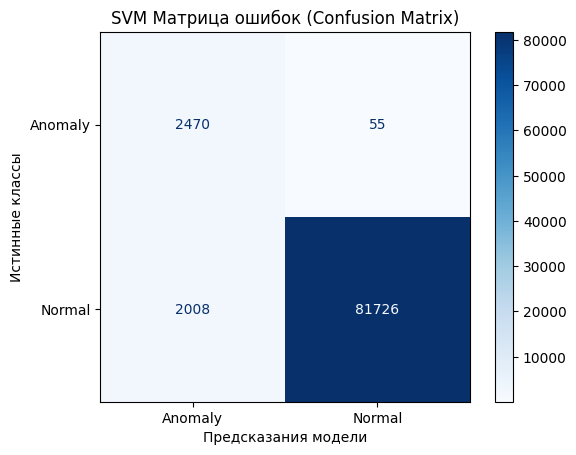

In [209]:
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_svm,
        display_labels=['Anomaly', 'Normal']
)
disp.plot(cmap="Blues")
plt.title("SVM Матрица ошибок (Confusion Matrix)")
plt.xlabel("Предсказания модели")
plt.ylabel("Истинные классы")
plt.show()


Модель хорошо предсказывает аномали (f1 = 0.98), но много нормальных последовательностей классифицирует как аномали (f1 = 0.7).

Выбранный параметр оценки качества модели f1 зависит от уровня вероятности. Следует рассмотреть независимые от уровня вероятности оценки качества предсказаний модели.

В модели использованы простые параметры, для повышения качества предсказания необходимо создание новых параметров. 

Следует определить влияние параметров модели на качество предсказания модели. Подобрать оптимальные параметры модели, создавая новые параметры на основе датасета.

В дальнейшем исследовании необходимо определить оптимальные гиперпараметры моделит.